In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


# 공식문서 참고
# Floating point precision can be set:

# >>> np.set_printoptions(precision=4)
# >>> np.array([1.123456789])
# [1.1235]

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


In [65]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

# na_values: 결측치 값이 '?' 등의 다양한 모양으로 있을 수 있는데, 이들을 결측값으로 인식하라고 알려주는 것
# comment: if comment='#', parsing #empty\na,b,c\n1,2,3 with header=0 will result in 'a,b,c' being treated as the header.
# skipinitialspace: If True , the initial whitespaces will be removed.


데이터 정리

In [66]:
dataset = raw_dataset.copy()
dataset.tail()

# 원본을 유지하기 위해서 카피함

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [67]:
dataset = dataset.dropna()
dataset.isna().sum()
# 결측치 제거 됐는지 확인

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [68]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2:'Europe', 3:'Japan'})

# 원핫인코딩을 하지 않으면 1,2,3 숫자 사이에 순서나 대소관게가 형성될 수 있음.
# map을 이용해 각 숫자를 나라 이름으로 매핑해줌

In [69]:
# get_dummies를 이용해 원핫 인코딩을 해줌.

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


학습 밑 테스트로 분할

In [70]:
dataset.shape

(392, 10)

In [71]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 데이터셋을 트레인, 테스트로 8:2 분할, 원래 train_test_split(dataset,test_size=0.2)를
# 하는데 여기서는 특이하게 이렇게 했음

In [72]:
test_dataset.shape

(78, 10)

In [73]:
train_dataset.shape

(314, 10)

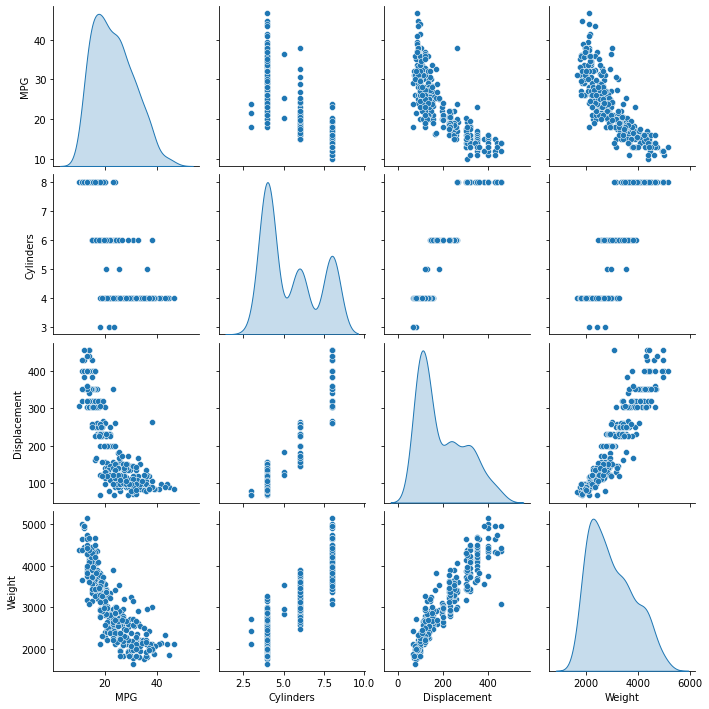

In [74]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

# diag_kind : {'auto', 'hist', 'kde', None} 대각선 subplot의 종류라고 함. 바꿔보기

In [75]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


레이블에서 피처 분할

In [76]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# 자동차의 연비에 관해서 분석을 진행하는 것이니 label은 MPG가 돼야함
# train, test 데이터셋에서 label을 각각 분리

In [77]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


정규화

정규화를 하는 이유
* 인풋의 크기가 아웃풋, 그리고 각 요소들의 크기에 영향을 줄 수 있음
* 정규화를 하면 학습이 보다 안정적으로 이루어짐

In [78]:
normalizer = preprocessing.Normalization(axis=-1)

In [79]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [80]:
normalizer.adapt(np.array(train_features))
#train_features 데이타를 layer에 adapt(적용) 시켜준다. 이 과정에서 각 feature별 평균과 표준편차 값이 계산된다. 

In [81]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [82]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


Linear regression

하나의 인풋   
멀티플 인풋   

DNN으로   
하나의 인풋   
멀티플 인풋   
이 순으로 진행됨

이를 test_results에 넣고 정확도를 비교할 것임

DNN은 은닉층을 2개이상 지닌 학습 방법을 뜻합니다. 컴퓨터가 스스로 분류레이블을 만들어 내고 공간을 왜곡하고 데이터를 구분짓는 과정을 반복하여 최적의 구번선을 도출해냅니다.

In [83]:
# 예측을 진행하는 것은 MPG(연비)이며 feature 하나만을 비교할 때는 Hoursepower을 선정했음.
# keras의 Sequential 모델을 이용할건데 두 가지 스텝으로 나뉩니다. 정규화, 그리고 댄스 레이어를 통해 아웃풋을 산출하는 것.
# 인풋의 수는 input_shape라는 어그멘트에 의해 결정될 수도 있고, 모델이 시행될 때 자동으로 결정되기도 합니다.

horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)   # 여기서는 input_shape의 모양을 넣어줌
horsepower_normalizer.adapt(horsepower)   # 정규화 적용하고 정보를 저장함

# 근데 전처리 과정에서 정규화를 진행해 줬는데 왜 다시 정규화를 하는지?

In [84]:
# Trainable params: 2 훈련 가능한 매개변수, weight과 bias가 하나씩 총 2개
# Non-trainable params 3개는?

horsepower_model = tf.keras.Sequential([
                                        horsepower_normalizer,
                                        layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [85]:
# 훈련되지 않은 모델로 10개만 돌려볼 거에요.
#결과는 그리 좋지 않지만 정상적으로 작동되는 것을 볼 수 있음.

horsepower_model.predict(horsepower[:10])

array([[-0.513],
       [-0.29 ],
       [ 0.946],
       [-0.719],
       [-0.65 ],
       [-0.255],
       [-0.77 ],
       [-0.65 ],
       [-0.169],
       [-0.29 ]], dtype=float32)

In [86]:
# 모델이 지어지면 컴파일을 이용해 옵티마이저와 로스를 설정해줄 수 있음.
# 로스를 통해 무엇을 적합하게 할 것인지, 그리고 optimizer을 통해 어떻게 할 것인지 결정하는 것임.

horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [130]:
# fit을 통해 예측 수행
# epoch(전체 반복 횟수)는 100, verbose는 몇 번 반복마다 정확도나 loss 등을 기록할지 설정하는 것임. 여기서는 0으로 함
# validation_split은 실제 test를 진행하기 전에 검증해보는 용도임. 0.2로 설정. 즉 train 80, validation 20임

%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.03 s, sys: 95 ms, total: 2.12 s
Wall time: 2.29 s


In [88]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803726,4.201833,95
96,3.803399,4.196851,96
97,3.803211,4.192951,97
98,3.806214,4.171106,98
99,3.805347,4.176302,99


In [89]:
# 그래프를 통해서 loss와 val_loss를 더욱 직관적으로 이해할 수 있음.

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

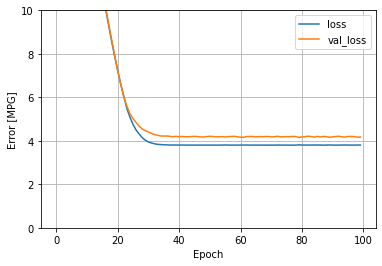

In [90]:
plot_loss(history)

In [91]:
# fit을 통해 실제 test를 수행하고, 그것을 test_results 딕셔너리에 담음. 

test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
test_results

{'horsepower_model': 3.6571056842803955}

In [92]:
# x: 0-250까지, 251개의 숫자를 생성

x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [93]:
train_features['Horsepower'].shape

(314,)

In [94]:
# 그래프로 hoursepower(마력)과 MPG의 산포도, 그리고 예측값을 비교해봄

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

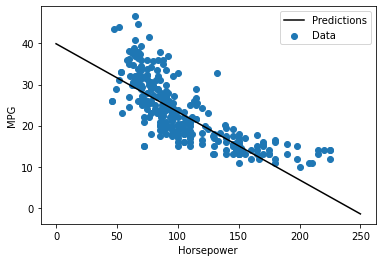

In [95]:
plot_horsepower(x, y)

Multiple inputs

In [138]:
# 앞에서 adapt로 정규화 적용한 normalizer (train_feature)을 인풋으로 넣어줌.

linear_model = tf.keras.Sequential([
                                    normalizer,
                                    layers.Dense(units=1)
])

In [135]:
linear_model.summary()

# trainable 10개: 9개의 weights, 1개의 bias
# 19개의 훈련하지 않아도 되는 변수가 생성됐음


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [98]:
horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [139]:
linear_model.predict(train_features[:10])

array([[-0.426],
       [ 0.643],
       [-1.162],
       [ 0.431],
       [ 1.827],
       [ 0.29 ],
       [ 1.957],
       [ 1.169],
       [-0.35 ],
       [ 1.331]], dtype=float32)

In [100]:
linear_model.layers[1].kernel

<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.483],
       [-0.52 ],
       [ 0.085],
       [ 0.079],
       [ 0.631],
       [ 0.55 ],
       [ 0.723],
       [-0.7  ],
       [-0.383]], dtype=float32)>

In [101]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [102]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2
)

CPU times: user 2.57 s, sys: 124 ms, total: 2.7 s
Wall time: 2.87 s


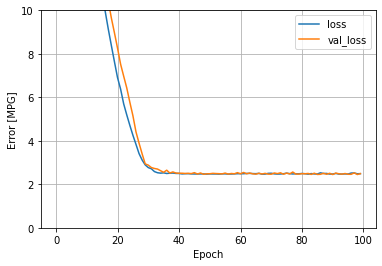

In [103]:
plot_loss(history)

In [104]:
# Loss가 더 작아진걸 확인할 수 있음.

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
test_results

{'horsepower_model': 3.6571056842803955, 'linear_model': 2.5173895359039307}

dnn_horsepower_model

A DNN regression

In [149]:
# 은닉층 2개, 아웃풋 레이어 1개로 이루어진 모델을 생성

def build_and_compile_model(norm):
  model = keras.Sequential([
                            norm,
                            layers.Dense(64, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [150]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [151]:
# 1*1 + 1 = 2 1은 뭔지 모르겠음
# 1*64 + 64 = 128
# 64*64+64 = 4160
# 64*1 + 1 = 65

dnn_horsepower_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [152]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.78 s, sys: 141 ms, total: 2.92 s
Wall time: 2.84 s


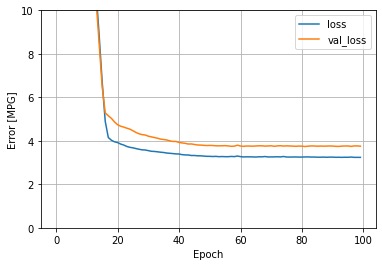

In [153]:
# loss랑 val_loss랑 차이가 조금 있긴 함.
plot_loss(history)

In [154]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

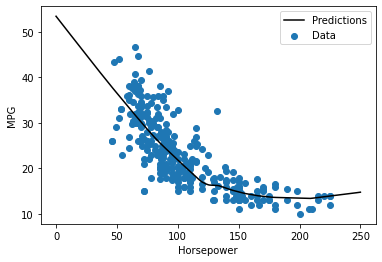

In [155]:
plot_horsepower(x, y)

In [161]:
# test_results에 저장

test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

test_results

{'dnn_horsepower_model': 2.8951468467712402,
 'dnn_model': 1.7523187398910522,
 'horsepower_model': 3.6571056842803955,
 'linear_model': 2.5173895359039307,
 'reloaded': 1.7523187398910522}

Full model

In [114]:
# 9*1 + 9 = 18, 1은 뭔지 모르겠음
# 9*64+64 = 640
# 64*64+64 = 4160

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [115]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.74 s, sys: 139 ms, total: 2.87 s
Wall time: 2.71 s


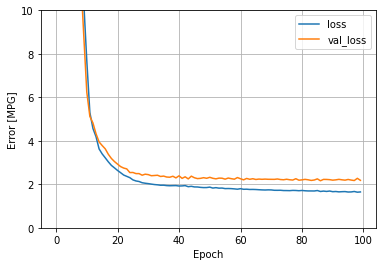

In [116]:
plot_loss(history)

In [117]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [163]:
# 테스트 결과를 담은 딕셔너리를 데이터프레임으로

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.657106
linear_model,2.517390
dnn_horsepower_model,2.895147
dnn_model,1.752319
reloaded,1.752319


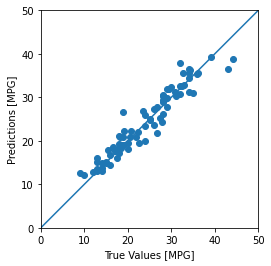

In [120]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

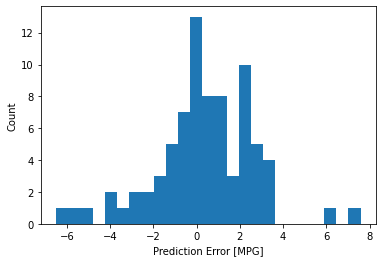

In [121]:
# 에러 = 예측값 - 실제값, 0 사이에 오밀조밀하게 모여있는 것을 확인할 수 있음.

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [122]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [123]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [124]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.657106
linear_model,2.517390
dnn_horsepower_model,2.876347
dnn_model,1.752319
reloaded,1.752319
